A very quick look at the evolving coronavirus cases in LA County, starting with Jan 21st, when the first case got diagnosed in the county. Data comes from the LA County Public Health website:
http://publichealth.lacounty.gov/media/Coronavirus/
I am updating the data as it comes in. 
:rocket:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import requests,datetime
from bs4 import BeautifulSoup
from datetime import timedelta


df = pd.read_csv('LACountyCovid.csv', header=0, index_col=0, squeeze=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'


In [2]:
print(df.tail())

pop_Ro = 19530000
pop_LA = 10118759
pop_MS = 2987000
df['Ro_Conf_prop'] = df.apply(lambda row: row['RO-confirmed'] * 1000000 / pop_Ro, axis = 1) 
df['Ro_Deaths_prop'] = df.apply(lambda row: row['RO-deaths'] * 1000000 / pop_Ro, axis = 1) 
df['Ro_daily_prop'] = df.apply(lambda row: row['RO-daily'] * 1000000 / pop_Ro, axis = 1) 

df['LA_Conf_prop'] = df.apply(lambda row: row['confirmed cases'] * 1000000 / pop_LA, axis = 1) 
df['LA_Deaths_prop'] = df.apply(lambda row: row['deaths'] * 1000000 / pop_LA, axis = 1) 
df['LA_daily_prop'] = df.apply(lambda row: row['daily cases'] * 1000000 / pop_LA, axis = 1) 

df['MS_Conf_prop'] = df.apply(lambda row: row['MS-confirmed'] * 1000000 / pop_MS, axis = 1) 
df['MS_Deaths_prop'] = df.apply(lambda row: row['MS-deaths'] * 1000000 / pop_MS, axis = 1) 
df['MS_daily_prop'] = df.apply(lambda row: row['MS-daily'] * 1000000 / pop_MS, axis = 1) 
print(df.tail())

            confirmed cases  deaths  hospitalized  daily cases month  \
date                                                                   
2020-11-07         322207.0  7172.0         851.0       2238.0   Nov   
2020-11-08         323625.0  7177.0         855.0       1431.0   Nov   
2020-11-09         325876.0  7200.0         888.0       2318.0   Nov   
2020-11-10              NaN     NaN           NaN          NaN   Nov   
2020-11-11              NaN     NaN           NaN          NaN   Nov   

            RO-confirmed  RO-deaths  RO-hospitalized  RO-daily  MS-confirmed  \
date                                                                           
2020-11-07      296999.0     7793.0              NaN    9937.0      127205.0   
2020-11-08      303751.0     7879.0              NaN    6752.0      128138.0   
2020-11-09      306991.0     8009.0              NaN    3240.0           NaN   
2020-11-10      314295.0     8186.0              NaN    7304.0           NaN   
2020-11-11     

In [3]:
df['DailyDeaths'] = df['deaths'].diff(1)
df['DailyDeathsRo'] = df['RO-deaths'].diff(1)
df['DailyDeathsMs'] = df['MS-deaths'].diff(1)

In [4]:
class HTMLTableParser:
       
        def parse_url(self, url):
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'lxml')
            return [(table['id'],self.parse_html_table(table))\
                    for table in soup.find_all('table')]  
    
        def parse_html_table(self, table):
            n_columns = 0
            n_rows=0
            column_names = []
    
            # Find number of rows and columns
            # we also find the column titles if we can
            for row in table.find_all('tr'):
                
                # Determine the number of rows in the table
                td_tags = row.find_all('td')
                if len(td_tags) > 0:
                    n_rows+=1
                    if n_columns == 0:
                        # Set the number of columns for our table
                        n_columns = len(td_tags)
                        
                # Handle column names if we find them
                th_tags = row.find_all('th') 
                if len(th_tags) > 0 and len(column_names) == 0:
                    for th in th_tags:
                        column_names.append(th.get_text())
    
            # Safeguard on Column Titles
            if len(column_names) > 0 and len(column_names) != n_columns:
                raise Exception("Column titles do not match the number of columns")
    
            columns = column_names if len(column_names) > 0 else range(0,n_columns)
            df = pd.DataFrame(columns = columns,
                              index= range(0,n_rows))
            row_marker = 0
            for row in table.find_all('tr'):
                column_marker = 0
                columns = row.find_all('td')
                for column in columns:
                    df.iat[row_marker,column_marker] = column.get_text()
                    column_marker += 1
                if len(columns) > 0:
                    row_marker += 1
                    
            # Convert to float if possible
            for col in df:
                try:
                    df[col] = df[col].astype(float)
                except ValueError:
                    pass
            
            return df

In [5]:
def scrapeGlobalCase (url):
    try:
        #url = "https://www.worldometers.info/coronavirus/"
        req = requests.get(url)
        bsObj = BeautifulSoup(req.text, "html.parser")
        data = bsObj.find_all("div",class_ = "maincounter-number")
        NumConfirmed = int(data[0].text.strip().replace(',', ''))
        NumDeaths = int(data[1].text.strip().replace(',', ''))
        NumRecovered = int(data[2].text.strip().replace(',', ''))
        NumActive = NumConfirmed - NumDeaths - NumRecovered
        TimeNow = datetime.datetime.now()
        return {
            'date': str(TimeNow),
            'ConfirmedCases': NumConfirmed,
            'ActiveCases': NumActive,
            'RecoveredCases': NumRecovered,
            'Deaths': NumDeaths
        }
    except Exception as e: print(e)




In [6]:
def scrapeLACounty (url):
    try:
        hp = HTMLTableParser()
        
        table = hp.parse_url(url)[0][1] # Grabbing the table from the tuple
        la_row = table.iloc[1]
        NumConfirmed = int(''.join(filter(str.isdigit, la_row['TotalCases'])))
        NumDeaths = int(''.join(filter(str.isdigit, la_row['TotalDeaths'])))
        NumRecovered = 0
        NumActive = 0
        TimeNow = datetime.datetime.now()
        return {
            'date': str(TimeNow),
            'ConfirmedCases': NumConfirmed,
            'ActiveCases': NumActive,
            'RecoveredCases': NumRecovered,
            'Deaths': NumDeaths
        }
    except Exception as e: print(e)


In [7]:
url_ro = "https://www.worldometers.info/coronavirus/country/romania/"
url_global = "https://www.worldometers.info/coronavirus/"
url_us = "https://www.worldometers.info/coronavirus/country/us/"
url_california = "https://www.worldometers.info/coronavirus/usa/california/"
url_ms = "https://www.worldometers.info/coronavirus/usa/mississippi/"
url_la = "https://www.worldometers.info/coronavirus/usa/california/"

In [8]:
testResult = scrapeGlobalCase(url_global)
testRomania = scrapeGlobalCase(url_ro)
testUS = scrapeGlobalCase(url_us)
testCA = scrapeGlobalCase(url_california)
testMS = scrapeGlobalCase(url_ms)
testLA = scrapeLACounty(url_la)

In [9]:
import csv
with open('global_cases.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for key, value in testResult.items():
        writer.writerow([key, value])

In [10]:
from csv import DictWriter
def append_dict_as_row(file_name, dict_of_elem, field_names):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        dict_writer = DictWriter(write_obj, fieldnames=field_names)
        # Add dictionary as wor in the csv
        dict_writer.writerow(dict_of_elem)

In [11]:
list_global = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_all.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_global.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_global = pd.DataFrame(list_global, columns = cols)
df_global['ConfirmedCases'] = df_global['ConfirmedCases'].astype(str).astype(int)
df_global['ActiveCases'] = df_global['ActiveCases'].astype(str).astype(int)
df_global['RecoveredCases'] = df_global['RecoveredCases'].astype(str).astype(int)
df_global['Deaths'] = df_global['Deaths'].astype(str).astype(int)
df_global['DailyCases'] = df_global['ConfirmedCases'].diff(1)
df_global['DailyDeaths'] = df_global['Deaths'].diff(1)

#print(df_global.head())
#print(df_global.dtypes)

In [12]:
list_us = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_us.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_us.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_us = pd.DataFrame(list_us, columns = cols)
df_us['ConfirmedCases'] = df_us['ConfirmedCases'].astype(str).astype(int)
df_us['ActiveCases'] = df_us['ActiveCases'].astype(str).astype(int)
df_us['RecoveredCases'] = df_us['RecoveredCases'].astype(str).astype(int)
df_us['Deaths'] = df_us['Deaths'].astype(str).astype(int)
df_us['DailyCases'] = df_us['ConfirmedCases'].diff(1)
df_us['DailyDeaths'] = df_us['Deaths'].diff(1)

# Global cases and global deaths

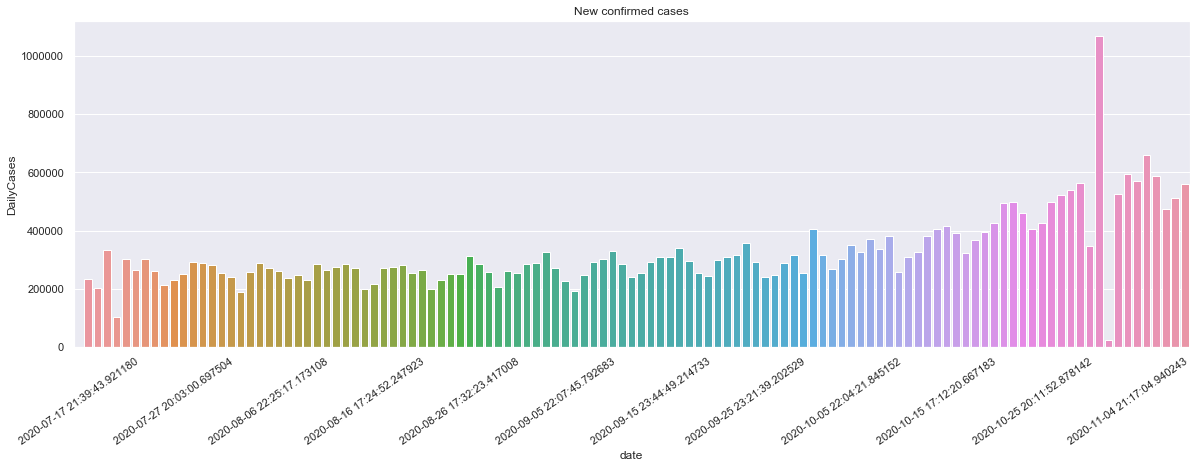

In [13]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.date, y = df_global['DailyCases'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases')

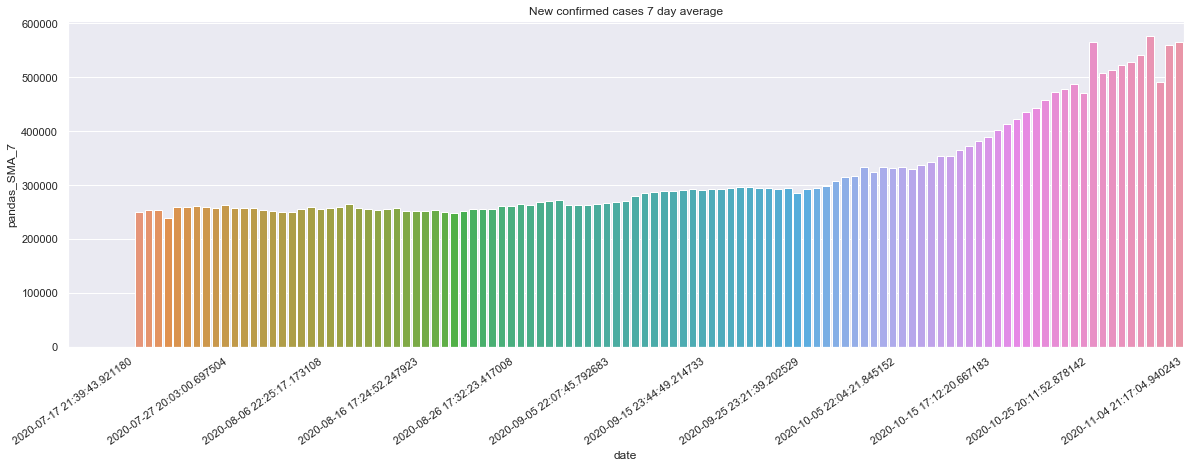

In [14]:
df_global['pandas_SMA_7'] = df_global['DailyCases'].rolling(window=7).mean()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.date, y = df_global['pandas_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases 7 day average')

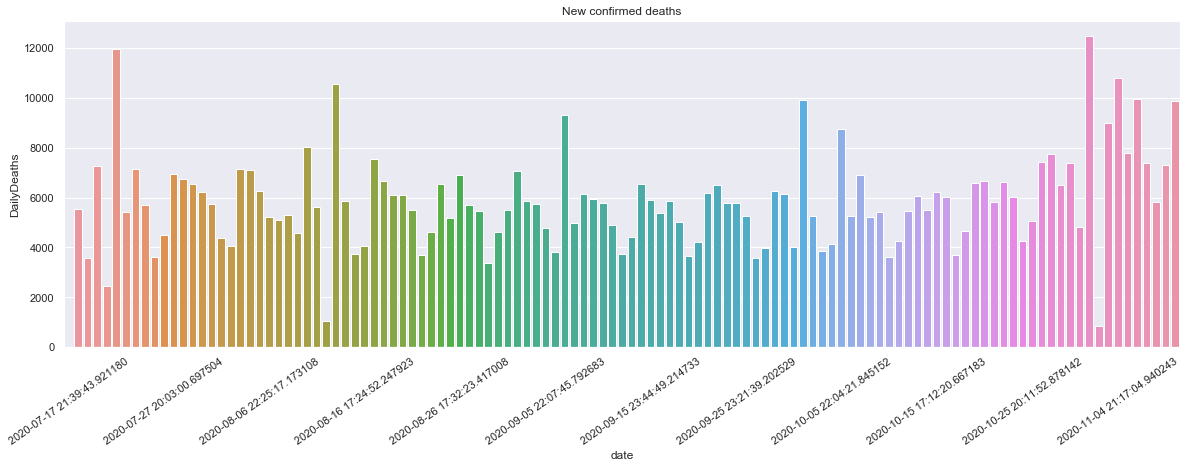

In [15]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.date, y = df_global['DailyDeaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths')

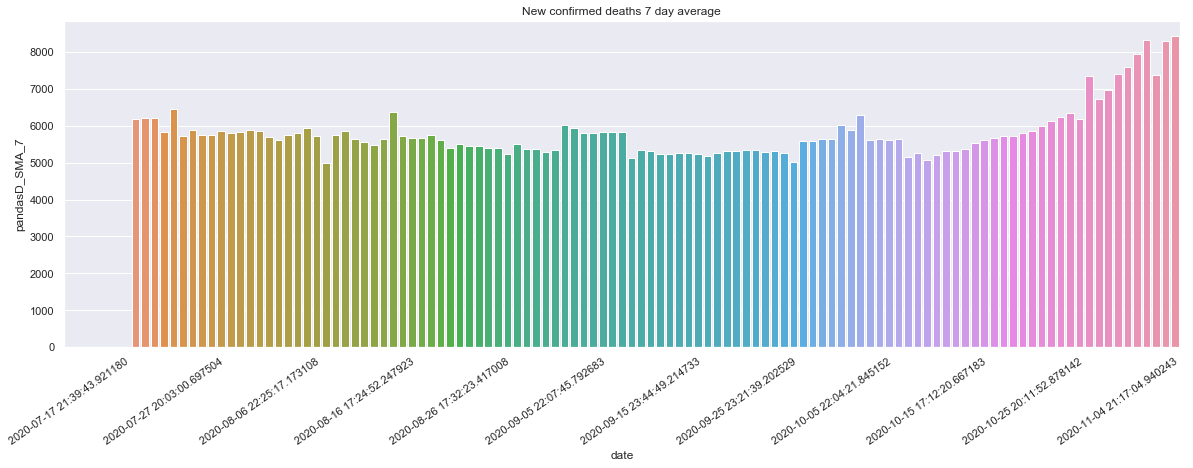

In [16]:
df_global['pandasD_SMA_7'] = df_global['DailyDeaths'].rolling(window=7).mean()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_global.date, y = df_global['pandasD_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths 7 day average')

# US cases and deaths

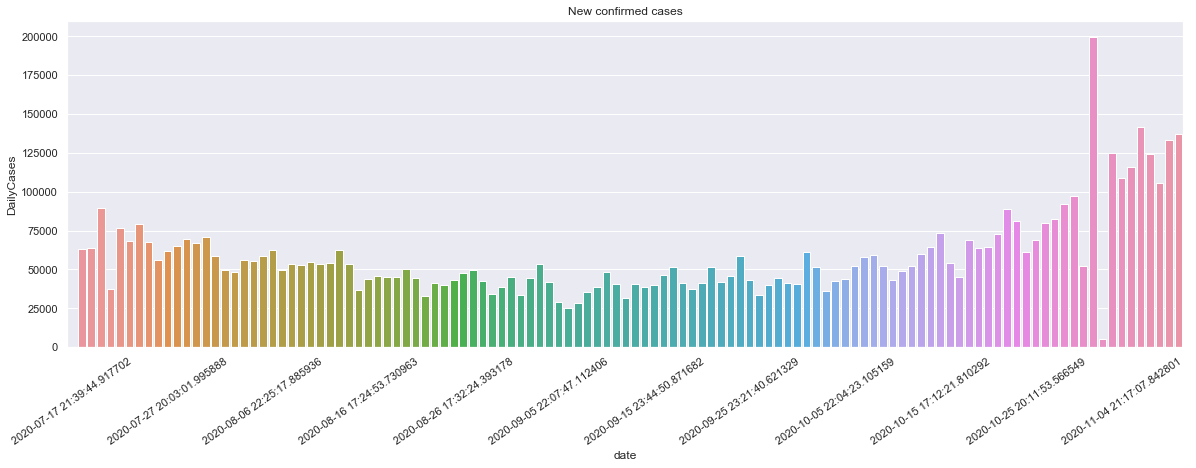

In [17]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_us.date, y = df_us['DailyCases'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases')

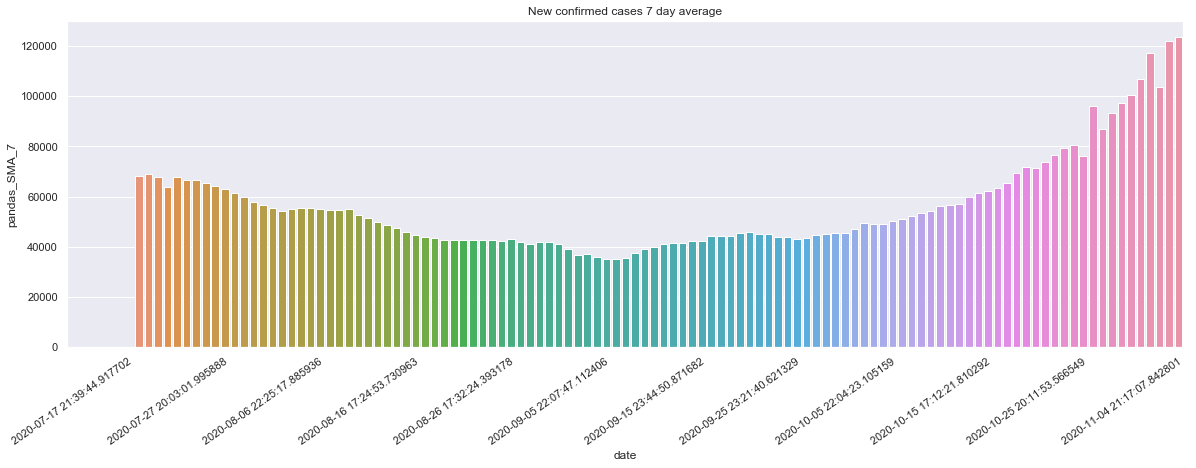

In [18]:
df_us['pandas_SMA_7'] = df_us['DailyCases'].rolling(window=7).mean()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_us.date, y = df_us['pandas_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases 7 day average')

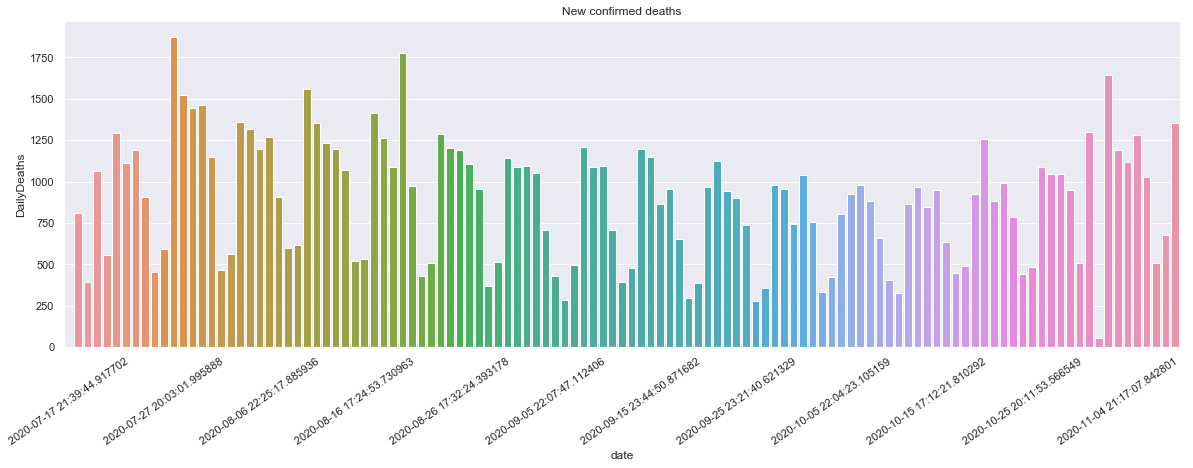

In [19]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_us.date, y = df_us['DailyDeaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths')

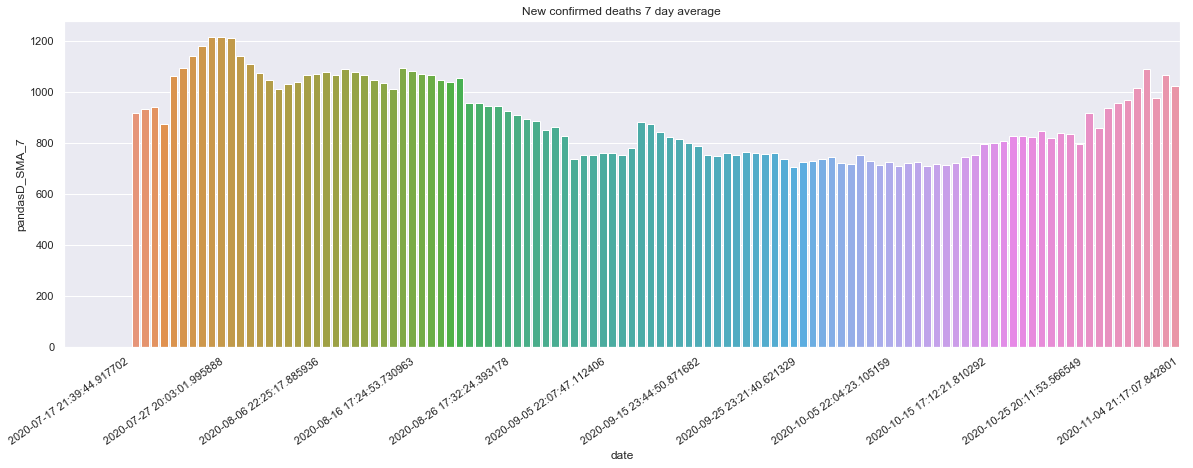

In [20]:
df_us['pandasD_SMA_7'] = df_us['DailyDeaths'].rolling(window=7).mean()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_us.date, y = df_us['pandasD_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths 7 day average')

Adding graphs showing cases/100000 people for each location for better comparison:
# Linear total cases per 1 000 000 people for LA County, Romania, and Mississippi 

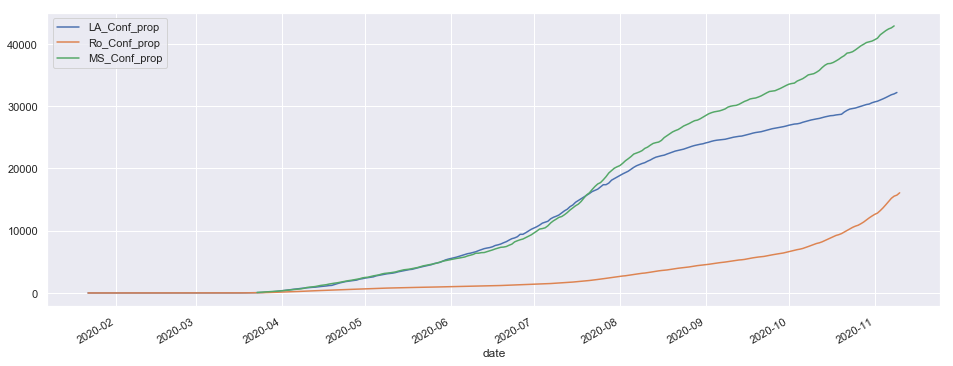

In [21]:
df[['LA_Conf_prop', 'Ro_Conf_prop', 'MS_Conf_prop']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log scale total cases per 1 000 000 people for LA County, Romania, and Mississippi 

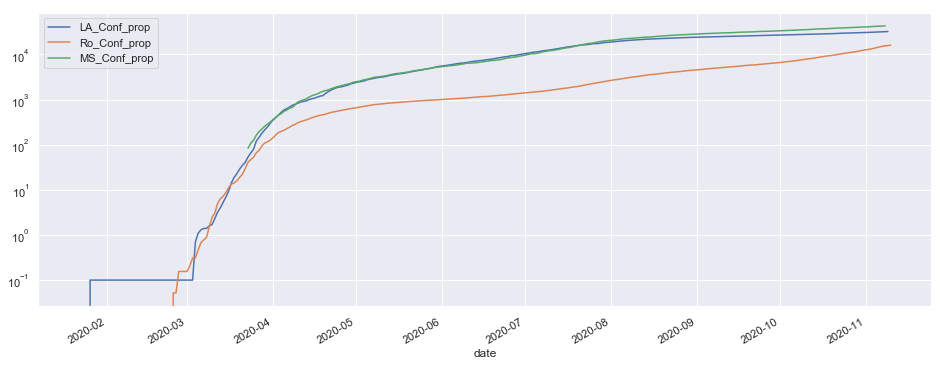

In [22]:
df[['LA_Conf_prop', 'Ro_Conf_prop', 'MS_Conf_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

# Linear deaths recorded per 1 000 000 people for LA County, Romania, and Mississippi 

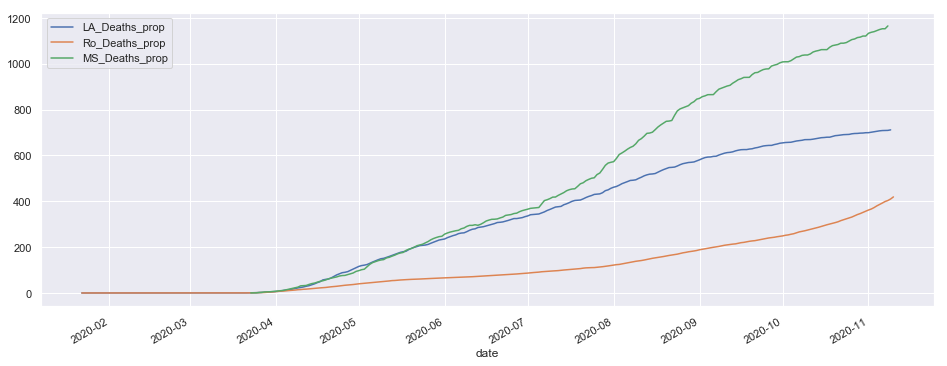

In [23]:
df[['LA_Deaths_prop', 'Ro_Deaths_prop', 'MS_Deaths_prop']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log deaths recorded per 1 000 000 people for LA County, Romania, and Mississippi 

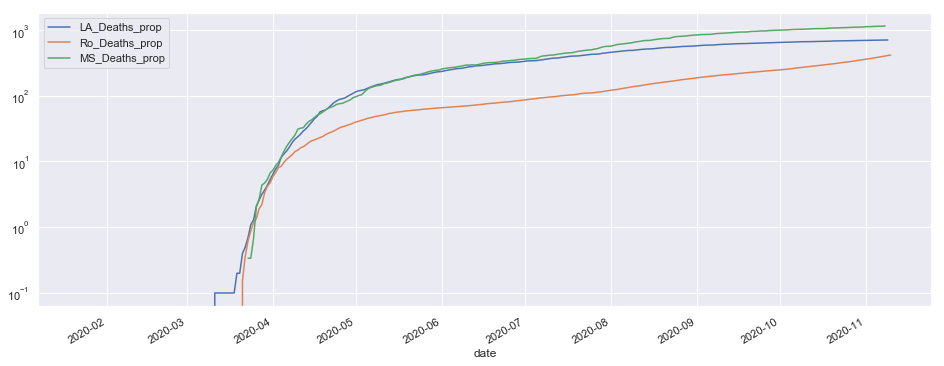

In [24]:
df[['LA_Deaths_prop', 'Ro_Deaths_prop', 'MS_Deaths_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

# Linear daily cases recorded per 1 000 000 people for LA County, Romania, and Mississippi 

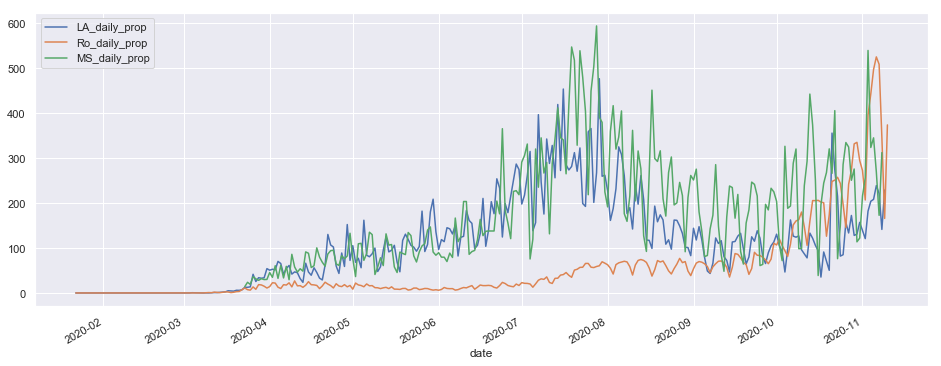

In [25]:
df[['LA_daily_prop', 'Ro_daily_prop', 'MS_daily_prop']].plot(x_compat=True, figsize=(16,6))
plt.legend(loc=2)
plt.show()

# Log daily cases recorded per 1 000 000 people for LA County, Romania, and Mississippi 

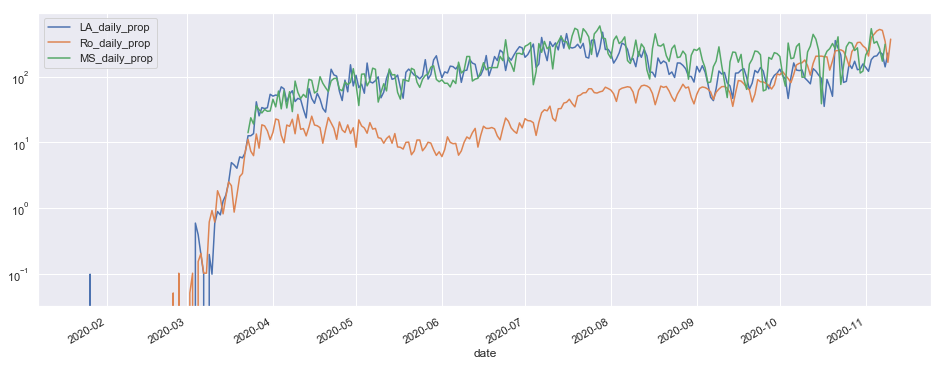

In [26]:
df[['LA_daily_prop', 'Ro_daily_prop', 'MS_daily_prop']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

# LA County daily cases

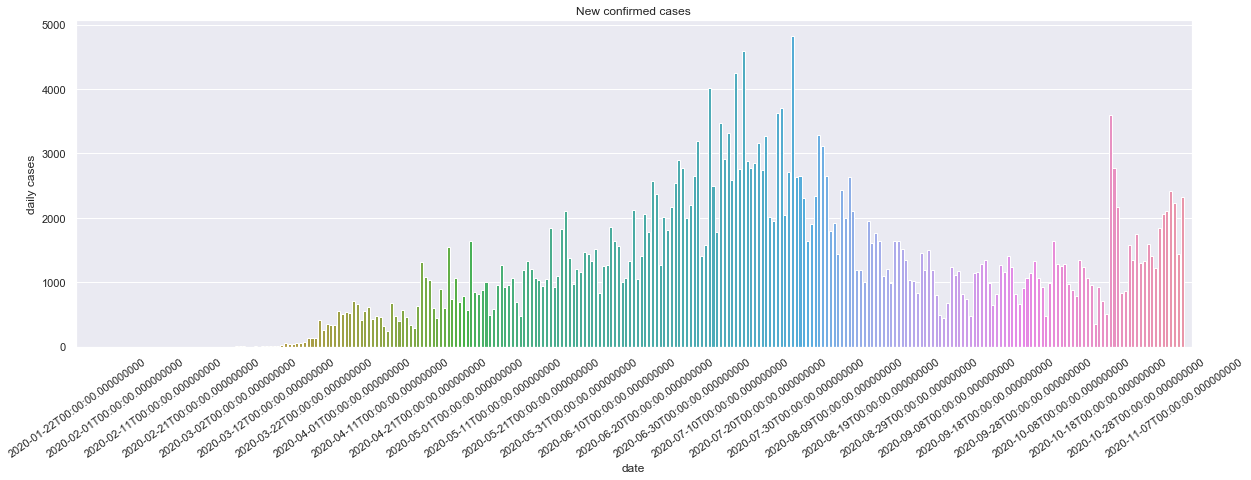

In [27]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['daily cases'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases')

Plot 7 day average for the LA County new cases:

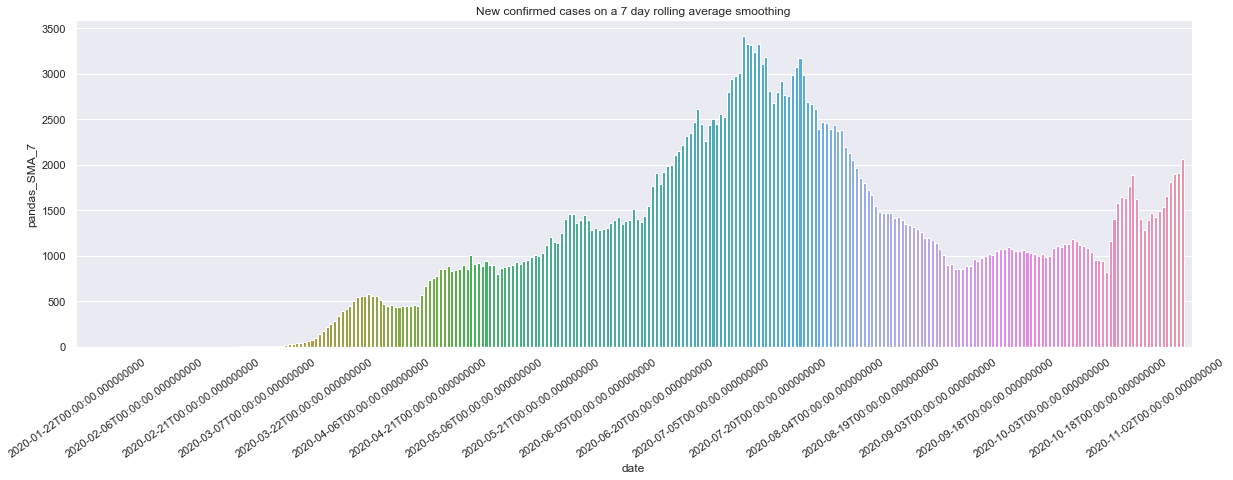

In [28]:
df['pandas_SMA_7'] = df['daily cases'].rolling(window=7).mean()
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['pandas_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 15 == 0:  # every 15th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases on a 7 day rolling average smoothing')

# LA County daily deaths raw and 7-day average

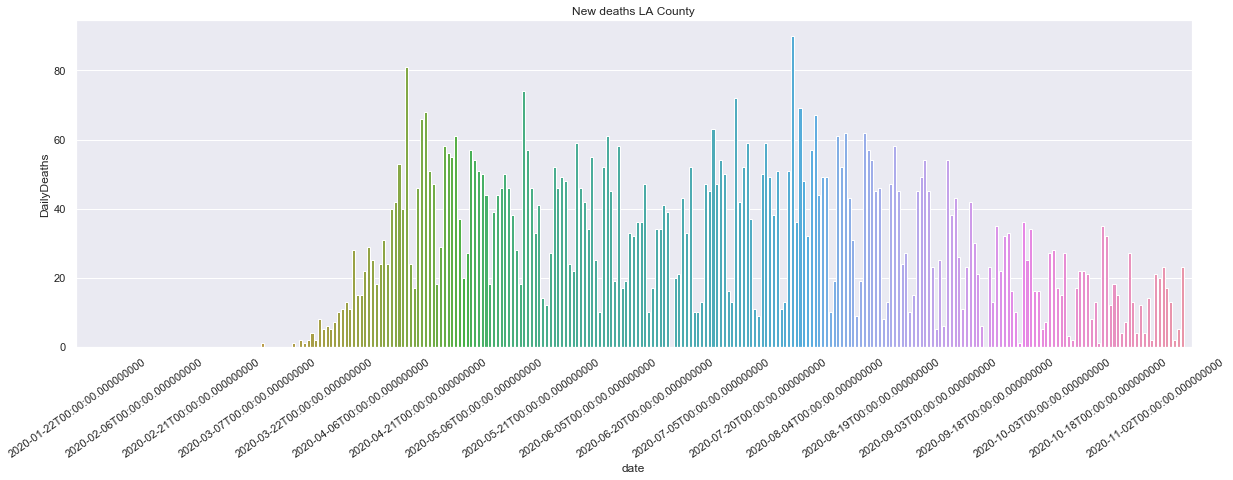

In [29]:

sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['DailyDeaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 15 == 0:  # every 15th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New deaths LA County')

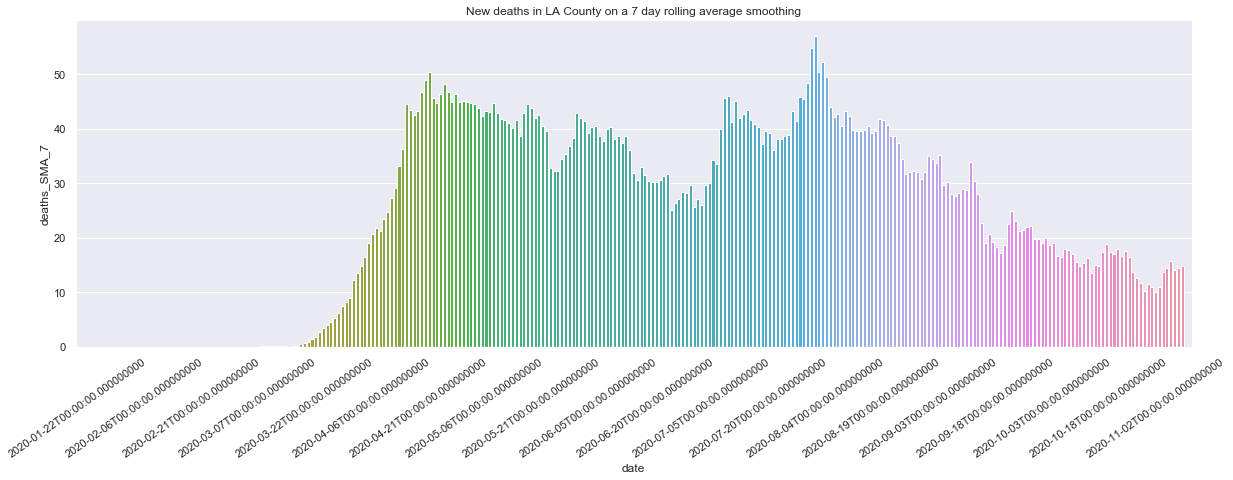

In [30]:
df['deaths_SMA_7'] = df['DailyDeaths'].rolling(window=7).mean()
#sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['deaths_SMA_7'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 15 == 0:  # every 15th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New deaths in LA County on a 7 day rolling average smoothing')

#                 Linear scale - all LA County data

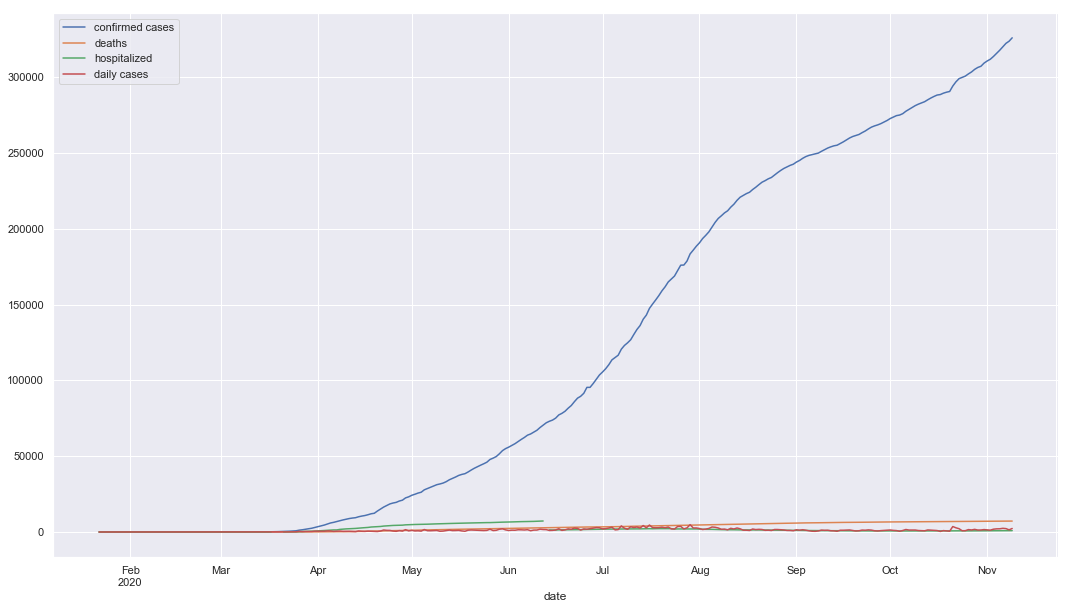

In [31]:
df_LA = df[['confirmed cases', 'deaths', 'hospitalized', 'daily cases']]
df_LA.plot(figsize=(18,10))
plt.show()

plot on a log scale to see the rate more accurately:
# Log scale - all LA County data

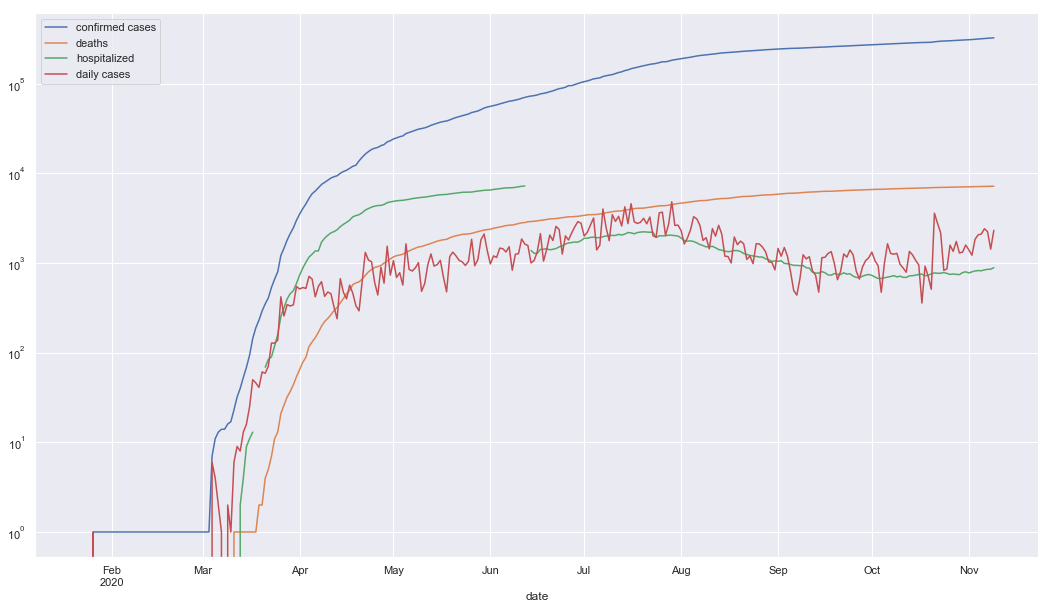

In [32]:
df_LA = df[['confirmed cases', 'deaths', 'hospitalized', 'daily cases']]
df_LA.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

A closer look at just the newly diagnosed cases every day (this is the more informative curve, which shows the number of people who have been sick and contagious for at least a week before they show up in this chart). The question is how many have these people infected before being diagnosed, and how much will this curve flatten in the next 2 weeks, when we're likely to start seeing the effects of the stay at home order. Cases in LA County in blue, in Romania in orange, and Mississippi in green)

# Linear scale - comparison of cases per day for LA, RO and MS

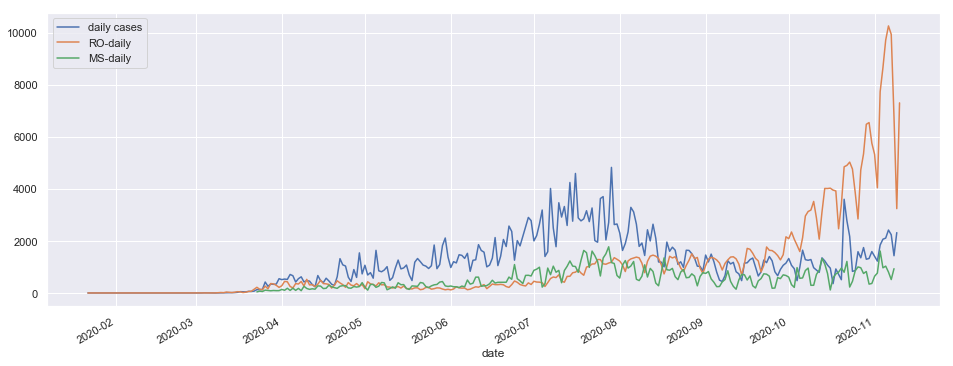

In [33]:
df[['daily cases','RO-daily', 'MS-daily']].plot(x_compat=True, figsize=(16,6))
plt.show()

# Log scale - comparison of cases per day for LA, RO and MS

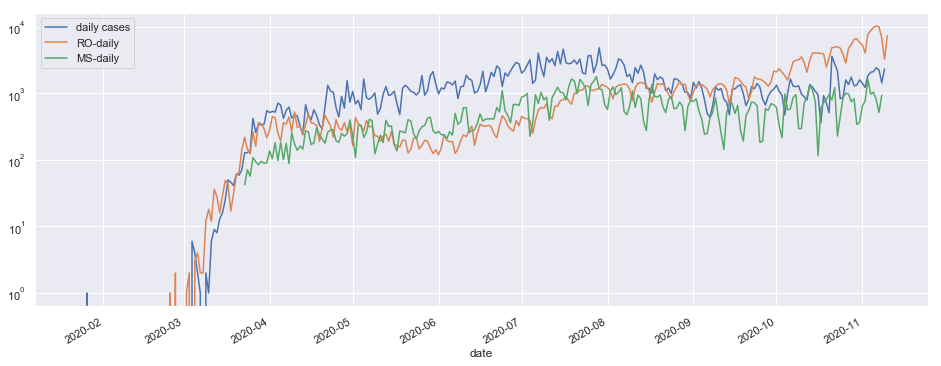

In [34]:
df[['daily cases','RO-daily', 'MS-daily']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

Nu am gasit date despre numarul de spitalizari in Romania - de aceea lipseste curba respectiva dupa data de 25 Martie.
# Linear scale - all data for Romania cases 

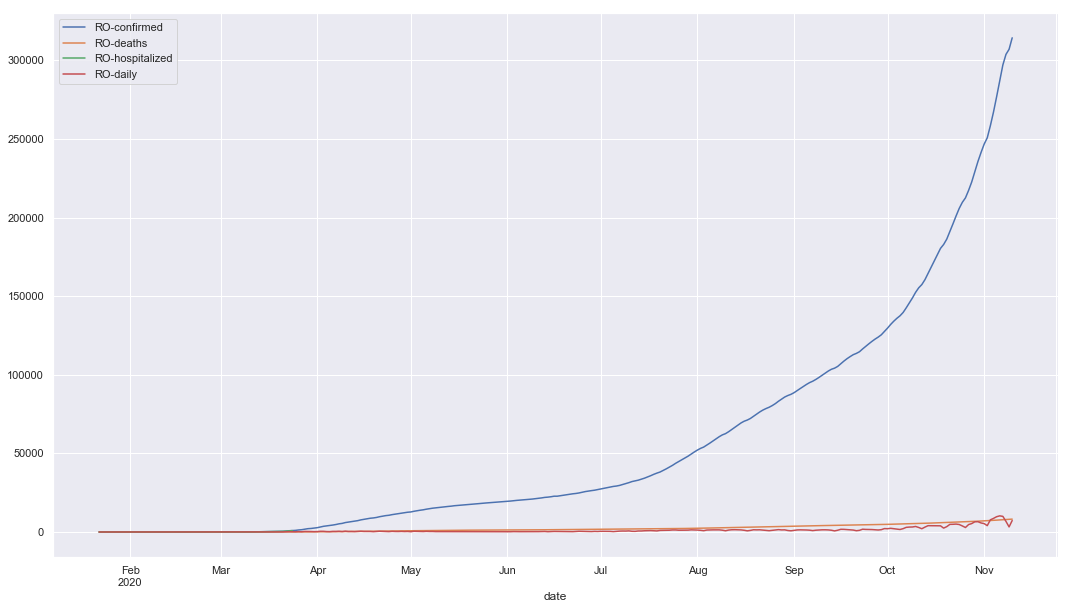

            RO-confirmed  RO-deaths  RO-hospitalized  RO-daily
date                                                          
2020-11-07      296999.0     7793.0              NaN    9937.0
2020-11-08      303751.0     7879.0              NaN    6752.0
2020-11-09      306991.0     8009.0              NaN    3240.0
2020-11-10      314295.0     8186.0              NaN    7304.0
2020-11-11           NaN        NaN              NaN       NaN


In [35]:
df_RO = df[['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']]
df_RO.plot(figsize=(18,10))
plt.show()
print(df_RO.tail())

# Log scale - all data for Romania cases 

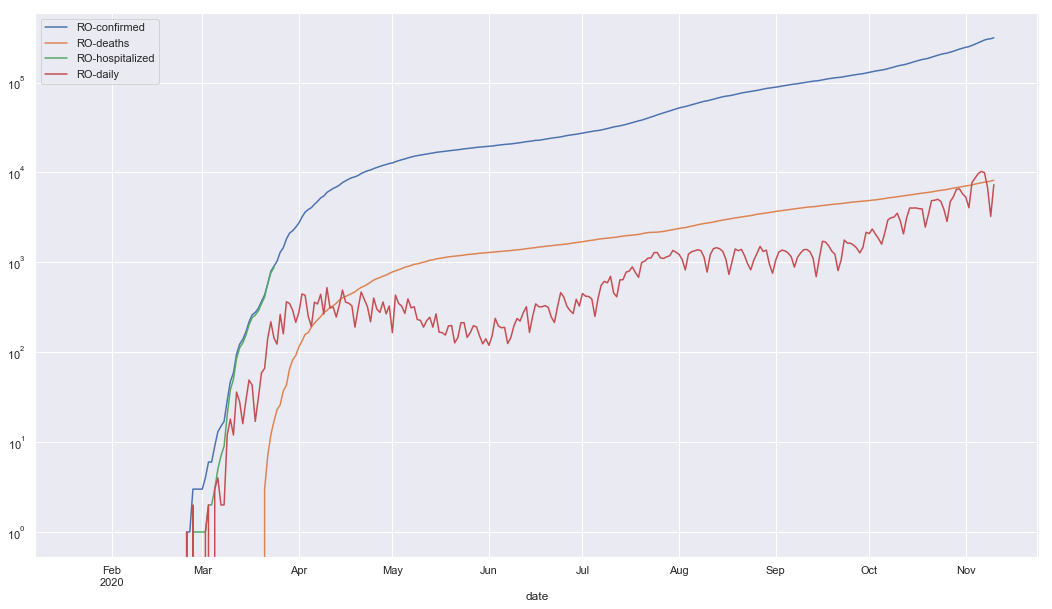

In [36]:
df_RO = df[['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']]
df_RO.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

Comparison LA County(total population 10 105 000 people) to Romania (population 19 500 000) as of 2018.  Starting with total confirmed cases:
Adding Mississippi - population of 3 980 000.

# Linear scale - all data for Mississippi cases 

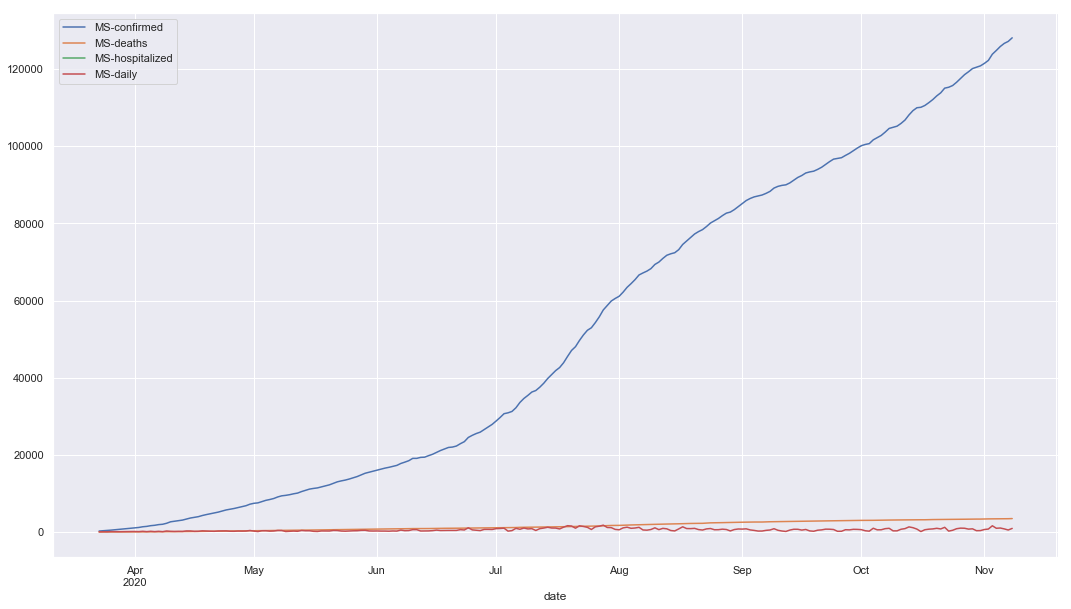

In [37]:
df_MS = df[['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']]
df_MS.plot(figsize=(18,10))
plt.show()

# Log scale - all data for Mississippi cases 

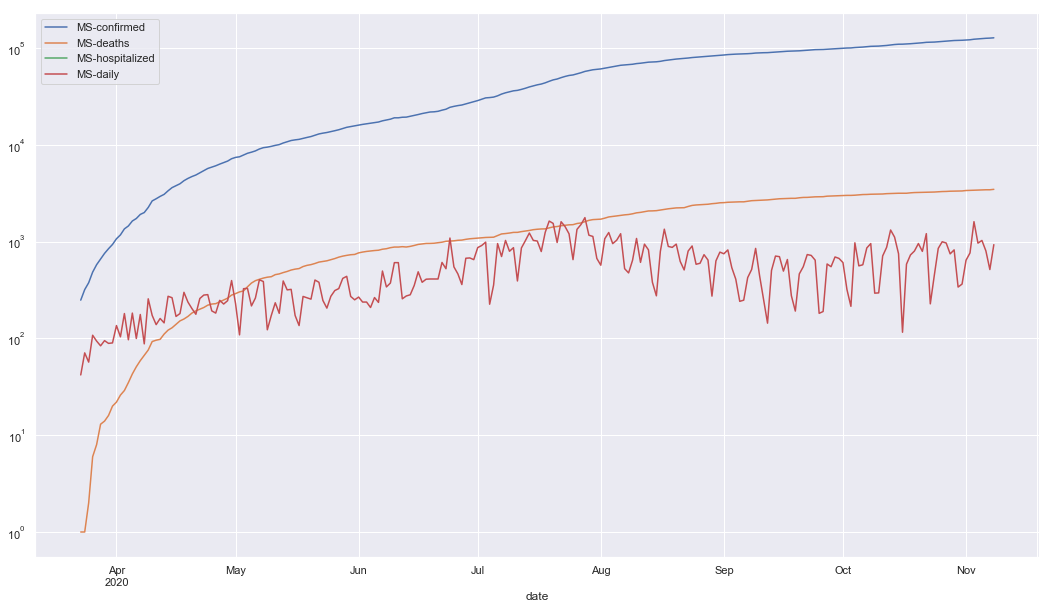

In [38]:
df_MS = df[['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']]
df_MS.plot(figsize=(18,10))
plt.yscale('log')
plt.show()

# Linear scale - comparison data for all confirmed cases to date for LA, MS and RO

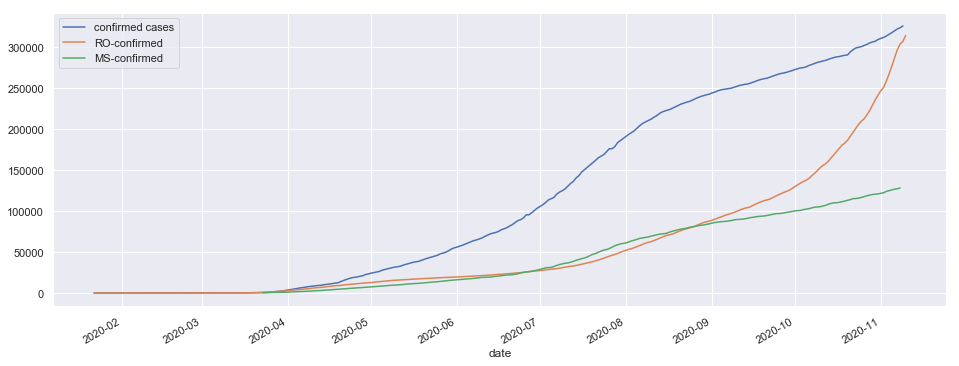

In [39]:
df[['confirmed cases','RO-confirmed', 'MS-confirmed']].plot(x_compat=True, figsize=(16,6))

plt.show()

# Log scale - comparison data for all confirmed cases to date for LA, MS and RO

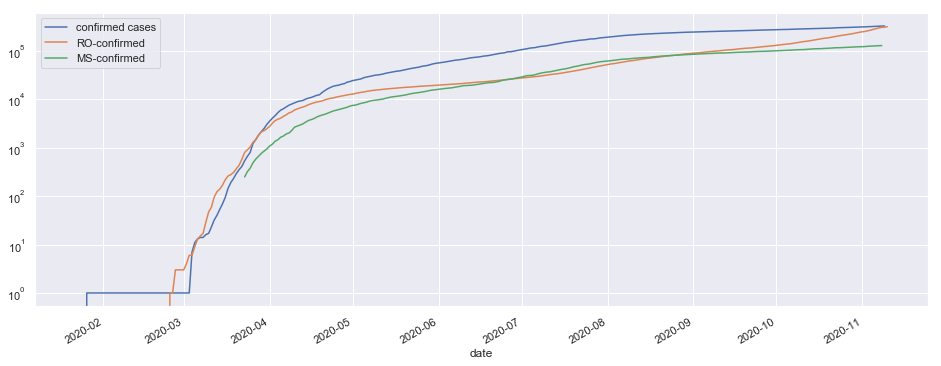

In [40]:
df[['confirmed cases','RO-confirmed', 'MS-confirmed']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

Comparison of number of deaths (cummulative) between LA County (blue curve) and Romania (orange curve). Adding Mississippi
# Linear scale - comparison data for all deaths to date for LA, MS and RO

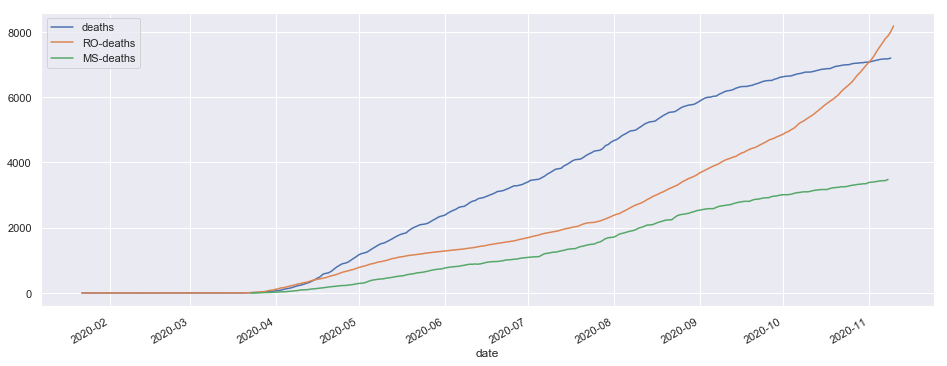

In [41]:
df[['deaths','RO-deaths', 'MS-deaths']].plot(x_compat=True, figsize=(16,6))

plt.show()

# Log scale - comparison data for all deaths to date for LA, MS and RO

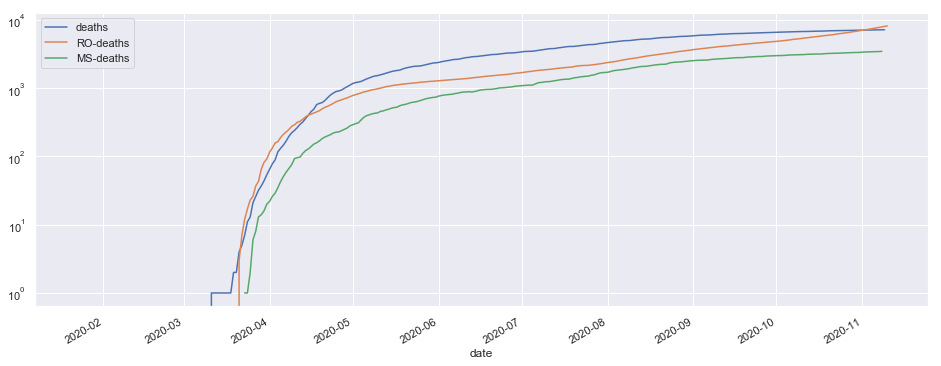

In [42]:
df[['deaths','RO-deaths', 'MS-deaths']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()


# Linear scale - comparison data for daily deaths for LA, MS and RO

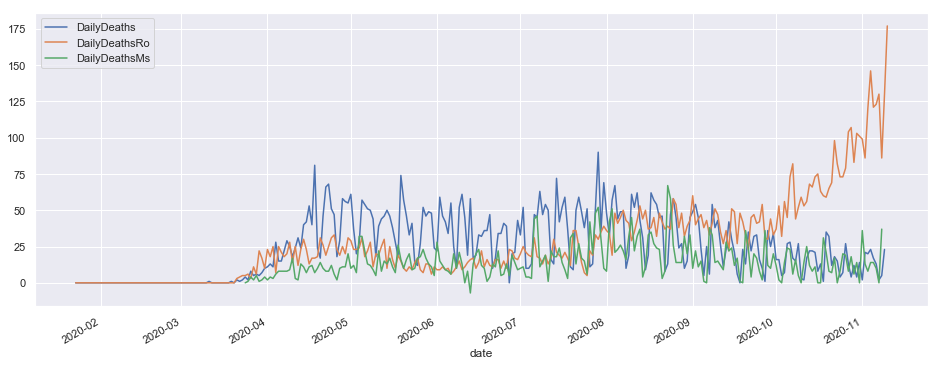

In [43]:
df[['DailyDeaths','DailyDeathsRo', 'DailyDeathsMs']].plot(x_compat=True, figsize=(16,6))

plt.show()

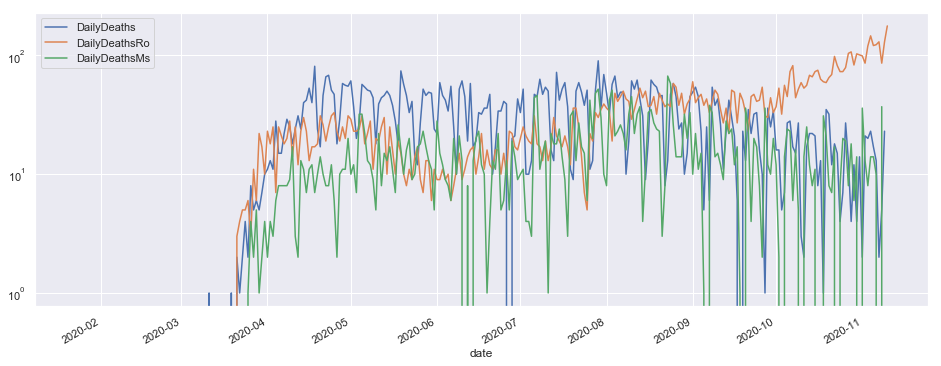

In [44]:
df[['DailyDeaths','DailyDeathsRo', 'DailyDeathsMs']].plot(x_compat=True, figsize=(16,6))
plt.yscale('log')
plt.show()

In [45]:
import requests,datetime
from bs4 import BeautifulSoup
from datetime import timedelta
  
URL = "http://publichealth.lacounty.gov/media/Coronavirus/"

r = requests.get(URL)  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.findAll('div', attrs = {'class':'counter-block counter-text'})



In [46]:
field_names = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
field_LA = ['confirmed cases', 'deaths', 'hospitalized', 'daily cases']
field_RO = ['RO-confirmed', 'RO-deaths', 'RO-hospitalized', 'RO-daily']
field_MS = ['MS-confirmed', 'MS-deaths', 'MS-hospitalized', 'MS-daily']
# Append a dict as a row in csv file
append_dict_as_row('global_cases_all.csv', testResult, field_names)
append_dict_as_row('global_cases_us.csv', testUS, field_names)
append_dict_as_row('global_cases_ro.csv', testRomania, field_names)
append_dict_as_row('global_cases_ca.csv', testCA, field_names)
append_dict_as_row('global_cases_ms.csv', testMS, field_names)
append_dict_as_row('global_cases_la.csv', testLA, field_names)

In [47]:
list_ro = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_ro.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_ro.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_ro = pd.DataFrame(list_ro, columns = cols)
df_ro['ConfirmedCases'] = df_ro['ConfirmedCases'].astype(str).astype(int)
df_ro['ActiveCases'] = df_ro['ActiveCases'].astype(str).astype(int)
df_ro['RecoveredCases'] = df_ro['RecoveredCases'].astype(str).astype(int)
df_ro['Deaths'] = df_ro['Deaths'].astype(str).astype(int)
df_ro['DailyCases'] = df_ro['ConfirmedCases'].diff(1)
df_ro['DailyDeaths'] = df_ro['Deaths'].diff(1)

df_ro.tail()

,date,ConfirmedCases,ActiveCases,RecoveredCases,Deaths,DailyCases,DailyDeaths
112,2020-11-07 19:43:39.576693,296999,88092,201114,7793,9937.0,130.0
113,2020-11-08 19:39:28.051416,303751,91193,204679,7879,6752.0,86.0
114,2020-11-09 20:00:59.733054,306991,92189,206793,8009,3240.0,130.0
115,2020-11-10 17:56:08.413214,314295,94701,211408,8186,7304.0,177.0
116,2020-11-10 20:09:27.524272,314295,94701,211408,8186,0.0,0.0


# Romania new cases and daily deaths

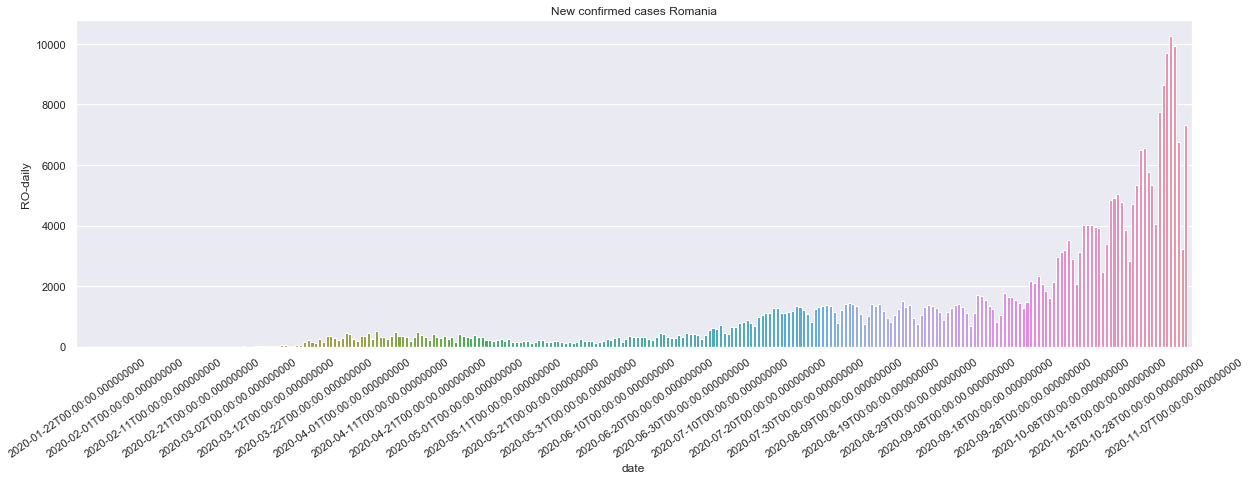

In [48]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['RO-daily'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases Romania')

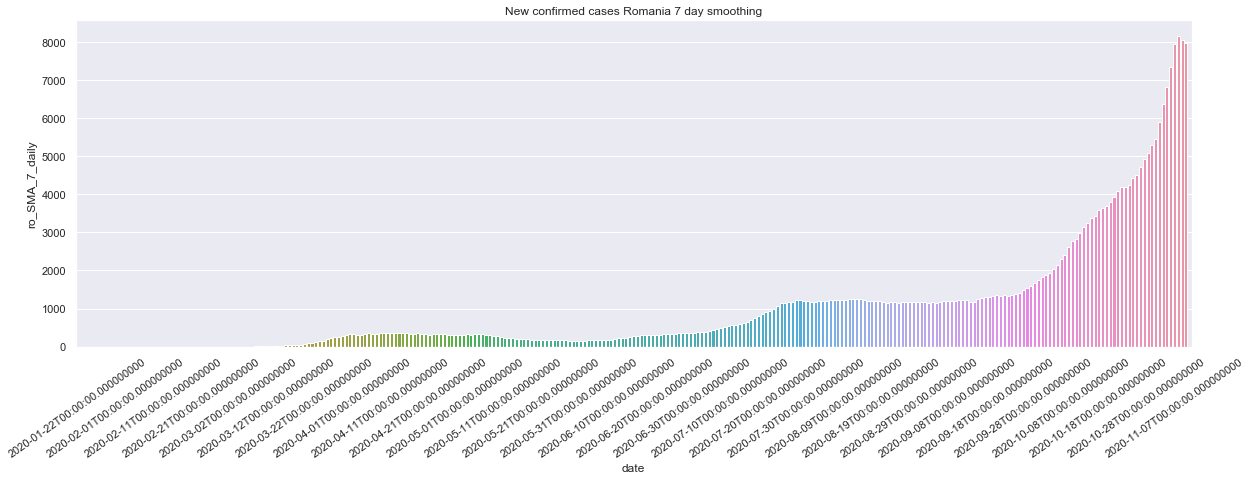

In [49]:
df['ro_SMA_7_daily'] = df['RO-daily'].rolling(window=7).mean()
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['ro_SMA_7_daily'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases Romania 7 day smoothing')

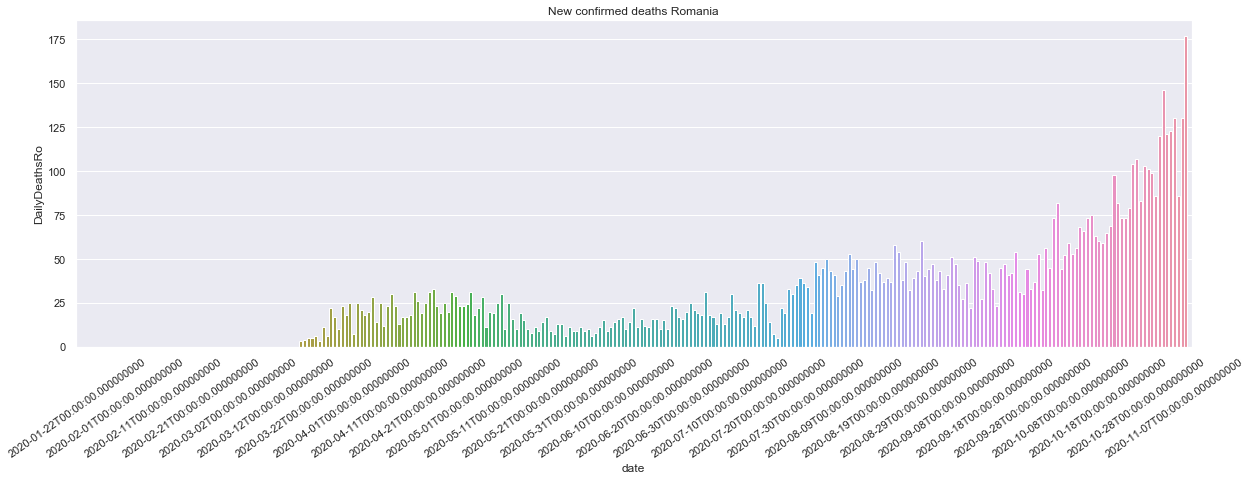

In [50]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['DailyDeathsRo'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths Romania')

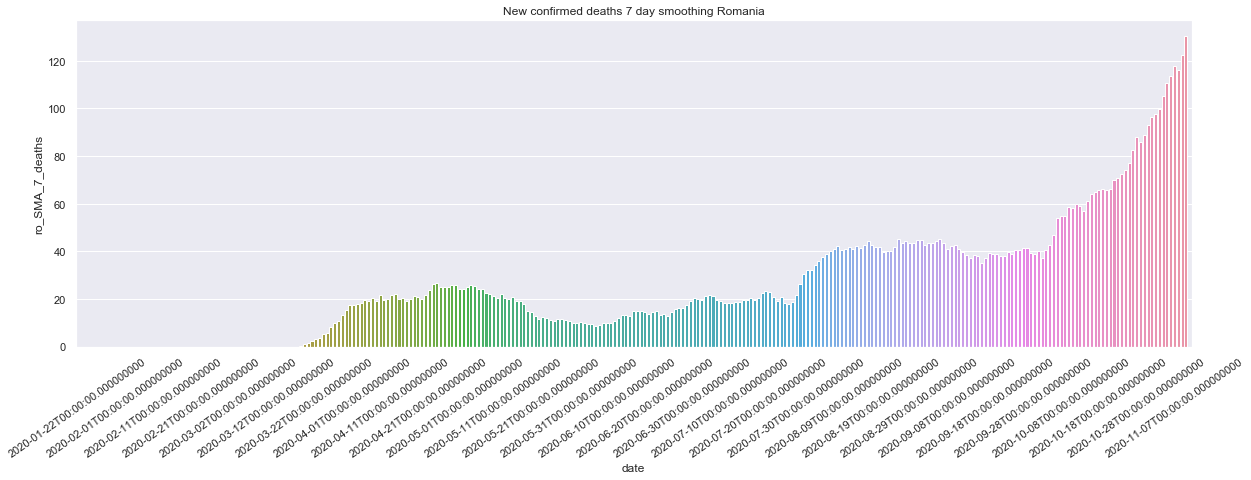

In [51]:
df['ro_SMA_7_deaths'] = df['DailyDeathsRo'].rolling(window=7).mean()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['ro_SMA_7_deaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths 7 day smoothing Romania')

In [52]:
list_ca = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_ca.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_ca.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_ca = pd.DataFrame(list_ca, columns = cols)
df_ca['ConfirmedCases'] = df_ca['ConfirmedCases'].astype(str).astype(int)
df_ca['ActiveCases'] = df_ca['ActiveCases'].astype(str).astype(int)
df_ca['RecoveredCases'] = df_ca['RecoveredCases'].astype(str).astype(int)
df_ca['Deaths'] = df_ca['Deaths'].astype(str).astype(int)
df_ca['DailyCases'] = df_ca['ConfirmedCases'].diff(1)
df_ca['DailyDeaths'] = df_ca['Deaths'].diff(1)

df_ca.tail()


,date,ConfirmedCases,ActiveCases,RecoveredCases,Deaths,DailyCases,DailyDeaths
107,2020-11-07 19:43:40.447914,970392,458159,494270,17963,4869.0,24.0
108,2020-11-08 19:39:29.261090,975712,462587,495148,17977,5320.0,14.0
109,2020-11-09 20:01:00.727205,983371,465863,499503,18005,7659.0,28.0
110,2020-11-10 17:56:09.541978,991810,471736,502004,18070,8439.0,65.0
111,2020-11-10 20:09:29.952436,991810,471736,502004,18070,0.0,0.0


# California daily cases and daily deaths

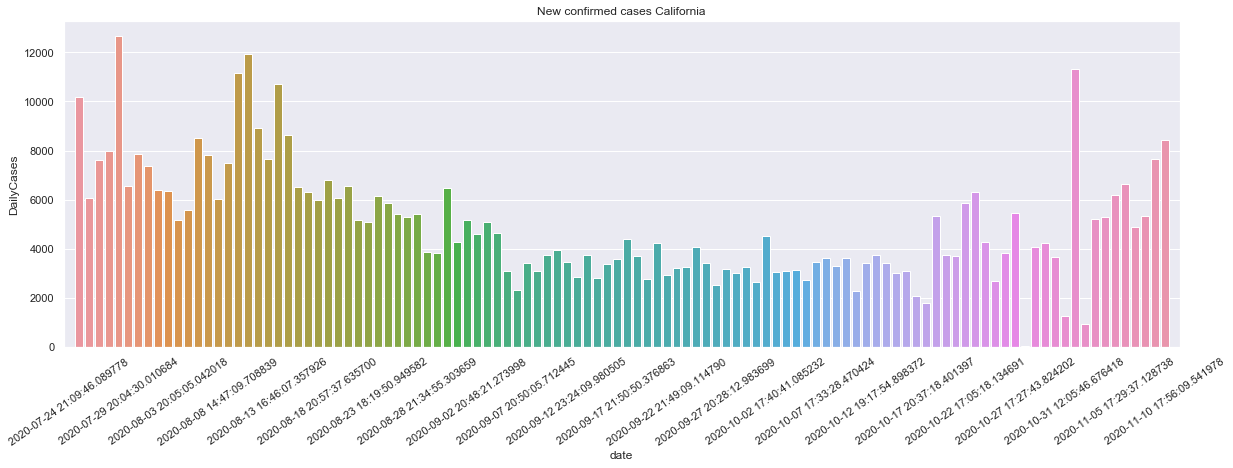

In [53]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ca.date, y = df_ca['DailyCases'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases California')

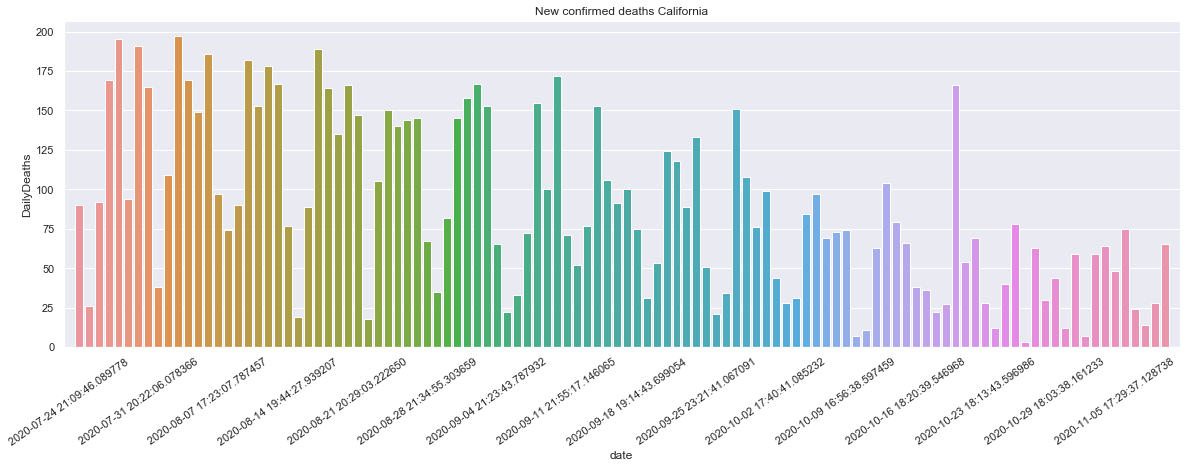

In [54]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df_ca.date, y = df_ca['DailyDeaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 7 == 0:  # every 7th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths California')

In [55]:
list_ms = []
cols = ['date','ConfirmedCases','ActiveCases','RecoveredCases','Deaths']
with open('global_cases_ms.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        list_ms.append([row['date'], row[' ConfirmedCases'], row[' ActiveCases'], row[' RecoveredCases'], row[' Deaths']])
df_ms = pd.DataFrame(list_ms, columns = cols)
df_ms['ConfirmedCases'] = df_ms['ConfirmedCases'].astype(str).astype(int)
df_ms['ActiveCases'] = df_ms['ActiveCases'].astype(str).astype(int)
df_ms['RecoveredCases'] = df_ms['RecoveredCases'].astype(str).astype(int)
df_ms['Deaths'] = df_ms['Deaths'].astype(str).astype(int)
df_ms['DailyCases'] = df_ms['ConfirmedCases'].diff(1)
df_ms['DailyDeaths'] = df_ms['Deaths'].diff(1)

df_ms.tail()

,date,ConfirmedCases,ActiveCases,RecoveredCases,Deaths,DailyCases,DailyDeaths
105,2020-11-07 19:43:41.045929,125885,16613,105839,3433,1031.0,14.0
106,2020-11-08 19:39:29.657874,126689,17407,105839,3443,804.0,10.0
107,2020-11-09 20:01:01.122784,127205,12332,111430,3443,516.0,0.0
108,2020-11-10 17:56:09.785713,128138,13228,111430,3480,933.0,37.0
109,2020-11-10 20:09:30.376145,128138,13228,111430,3480,0.0,0.0


# Mississippi daily cases and daily deaths

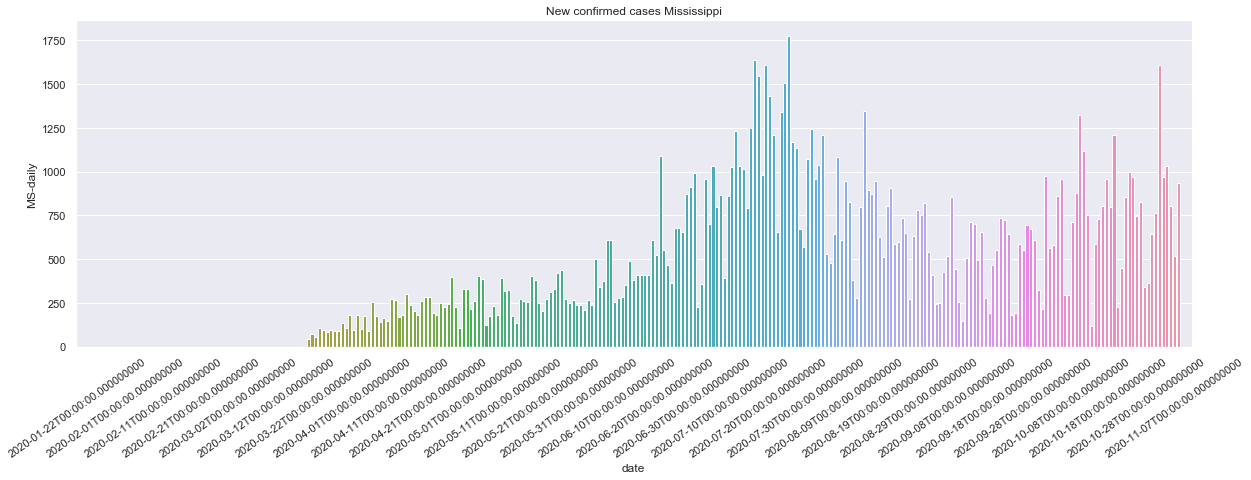

In [56]:
#sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['MS-daily'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases Mississippi')

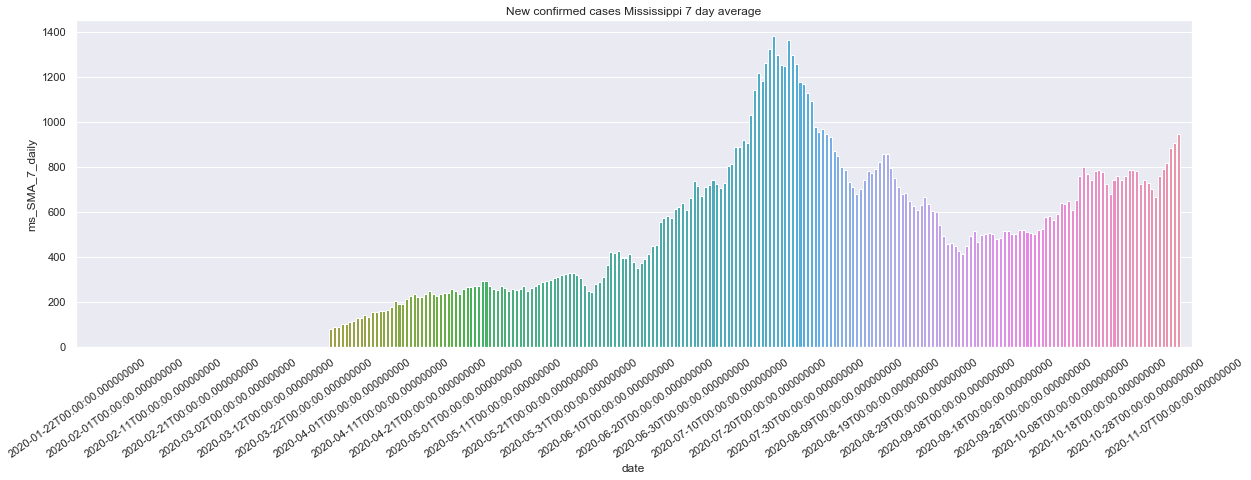

In [57]:
df['ms_SMA_7_daily']  =df['MS-daily'].rolling(window=7).mean()
#sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['ms_SMA_7_daily'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed cases Mississippi 7 day average')

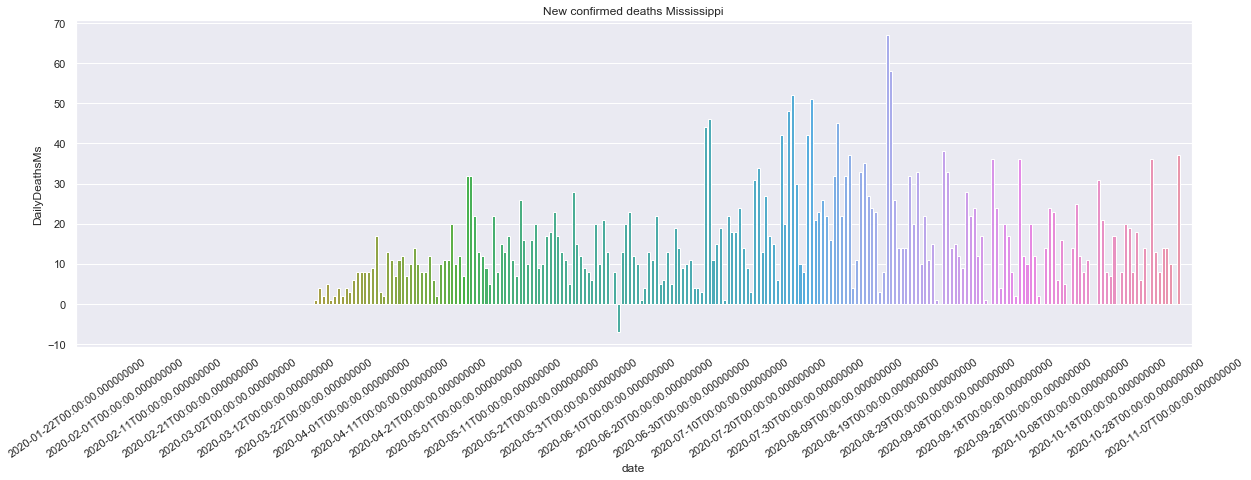

In [58]:
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['DailyDeathsMs'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths Mississippi')

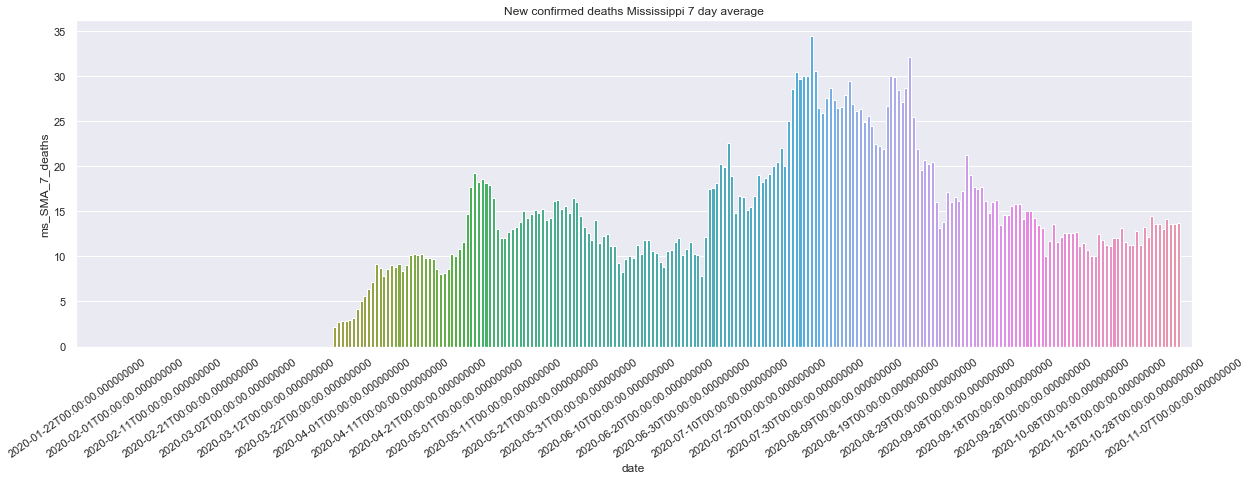

In [59]:
df['ms_SMA_7_deaths'] = df['DailyDeathsMs'].rolling(window=7).mean()
sns.set()
plt.figure(figsize = (20,6))
pl = sns.barplot(x = df.index, y = df['ms_SMA_7_deaths'])
for ind, label in enumerate(pl.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
_=plt.xticks( rotation=35)
_=pl.set_title('New confirmed deaths Mississippi 7 day average')

# 7 Day Average of daily new cases (LA, MS, Ro)

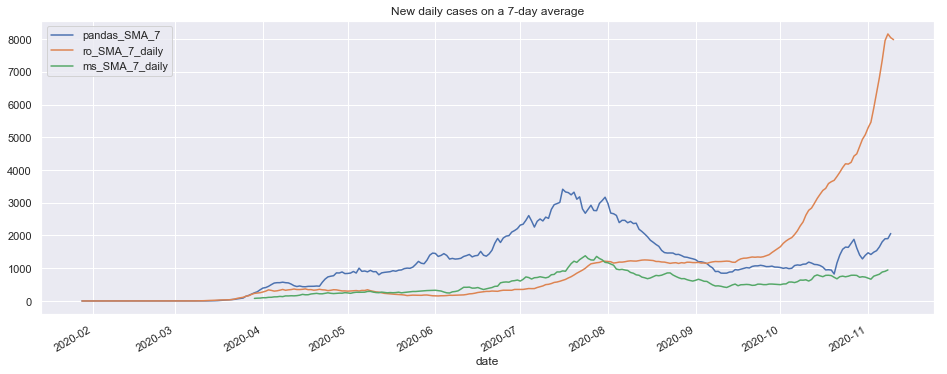

In [60]:
df[['pandas_SMA_7', 'ro_SMA_7_daily', 'ms_SMA_7_daily']].plot(x_compat = True, figsize = (16,6))
plt.title('New daily cases on a 7-day average')
plt.show()

# 7 Day Average of daily new cases per 1 000 000 people (LA, MS, Ro)

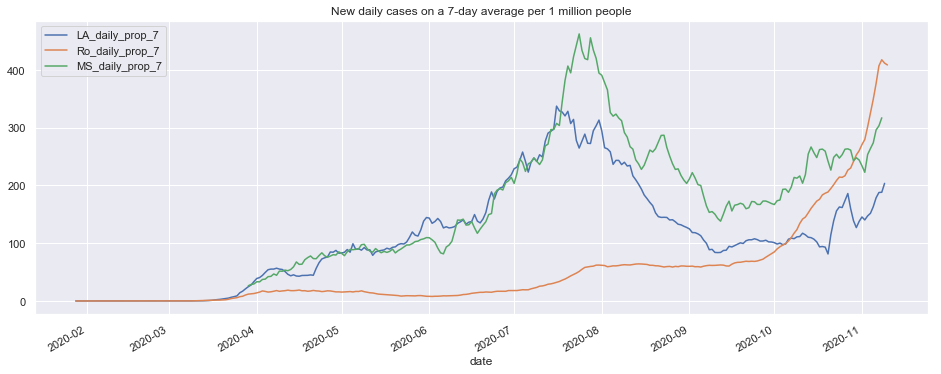

In [61]:
df['LA_daily_prop_7'] = df.apply(lambda row: row['pandas_SMA_7'] * 1000000 / pop_LA, axis = 1)
df['MS_daily_prop_7'] = df.apply(lambda row: row['ms_SMA_7_daily'] * 1000000 / pop_MS, axis = 1)
df['Ro_daily_prop_7'] = df.apply(lambda row: row['ro_SMA_7_daily'] * 1000000 / pop_Ro, axis = 1)
df[['LA_daily_prop_7', 'Ro_daily_prop_7', 'MS_daily_prop_7']].plot(x_compat = True, figsize = (16,6))
plt.title('New daily cases on a 7-day average per 1 million people')
plt.show()

# 7 Day Average of daily deaths (LA, MS, Ro)

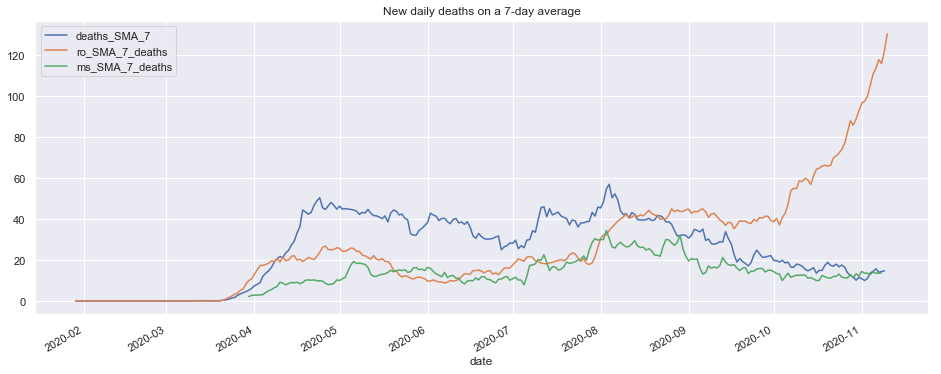

In [62]:
df[['deaths_SMA_7', 'ro_SMA_7_deaths', 'ms_SMA_7_deaths']].plot(x_compat=True, figsize=(16,6))
plt.title('New daily deaths on a 7-day average')
plt.show()

# 7 Day Average of daily deaths per 1 000 000 people (LA, MS, Ro)

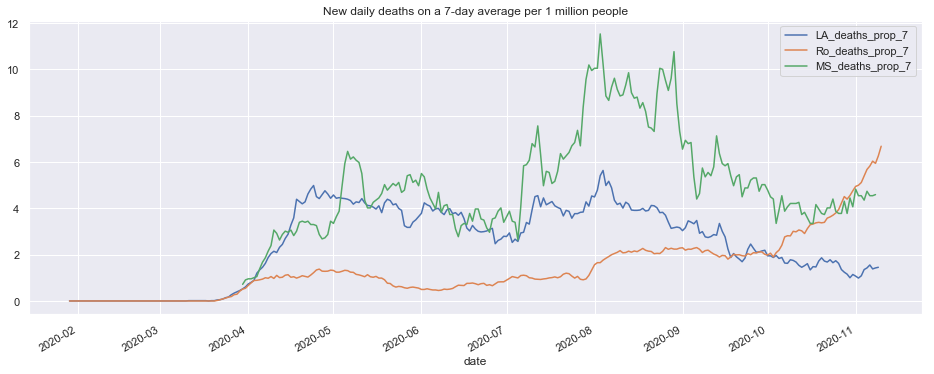

In [63]:
df['LA_deaths_prop_7'] = df.apply(lambda row: row['deaths_SMA_7'] * 1000000 / pop_LA, axis = 1)
df['MS_deaths_prop_7'] = df.apply(lambda row: row['ms_SMA_7_deaths'] * 1000000 / pop_MS, axis = 1)
df['Ro_deaths_prop_7'] = df.apply(lambda row: row['ro_SMA_7_deaths'] * 1000000 / pop_Ro, axis = 1)
df[['LA_deaths_prop_7', 'Ro_deaths_prop_7', 'MS_deaths_prop_7']].plot(x_compat=True, figsize=(16,6))
plt.title('New daily deaths on a 7-day average per 1 million people')
plt.show()

### This is the scraper for the LA County data straight out of the worldometer website - on the same page as the California numbers, but out of the table lower down.

In [64]:
hp = HTMLTableParser()
url = "https://www.worldometers.info/coronavirus/usa/california/"
table = hp.parse_url(url)[0][1] # Grabbing the table from the tuple
table.head()

,County,TotalCases,NewCases,TotalDeaths,NewDeaths,ActiveCases,TotalTests,Source
0,\nCalifornia Total\n,"991,810",\n,"18,070",\n,"471,736","\n20,094,641",
1,\nLos Angeles,"325,876",\n,"\n7,200",,\nN/A,"\n3,282,221",\n[county] [state]
2,\nRiverside,"72,341",\n,"\n1,352",,"\n7,265","\n897,264",\n[county] [state]
3,\nSan Bernardino,"70,347",\n,"\n1,096",,"\n3,913","\n888,164",\n[county] [state]
4,\nOrange,"62,830",\n,"\n1,512",,"\n5,988","\n1,197,862",\n[county] [state]


In [65]:
la_row = table.iloc[1]
int(la_row['TotalCases'].strip().replace(',', ''))

325876

In [66]:
s = la_row['TotalTests']
int(''.join(filter(str.isdigit, la_row['TotalTests'])))

3282221

In [67]:

from datetime import timedelta
  
#URL = "http://publichealth.lacounty.gov/media/Coronavirus/"
#URL = "http://publichealth.lacounty.gov/media/Coronavirus/data/index.htm#"
URL = "https://www.worldometers.info/coronavirus/usa/california/"
r = requests.get(URL)  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.find_all('table')[0] # Grab the first table
    

#dt_txt = soup.find('div', attrs = {'class': 'col-md-12 center'})
#all_text = dt_txt.get_text()
#new_dt = [int(s) for s in all_text.split() if s.isdigit()]
#print(new_dt)
#if len(table) > 2:
#    print('Need to take a look, format of page has changed')
#for row in table: 
#    print(row.text)
#    new_data.append(int(row.text))
     
#print(new_data)


TO DO: 
    1. improve and fix scrapers for data - done; still needed for LA County data - done
    2. plot 7 day averages - done;
    3. build prediction models